# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn import preprocessing as pp
from sklearn import metrics as m
import umap.umap_ as umap

from plotly import express as px

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 0.1 Helper Function

In [2]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def hyperparameter_tunning(model, clusters,data):
    # wss
    wss = kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
    wss.fit(data)
    # ss 
    ss = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
    ss.fit(data)
    df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
                       'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
    return df
   

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [3]:
df = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [4]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente resid

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [6]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [7]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [9]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

At this first, we'll simply remove the NAs.

In [10]:
# remove NAs
df1.dropna(subset=['description','customer_id'], inplace=True)
print('Percentage of Removed Values: {:.2f}'.format(1-(df1.shape[0]/df.shape[0])))

Percentage of Removed Values: 0.25


In [11]:
# Check NAs again 
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change data types

In [12]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [14]:
num = df1.select_dtypes(include=['int64','float64'])
cat = df1.select_dtypes(exclude=['int64','float64'])

### 1.7.1 Numerical Variables

In [15]:
# Central Tendency - Mean, Median

ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - Min, Max, Standard Deviation, Range, Skew, Kurtosis

d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(np.min)).T
d3 = pd.DataFrame(num.apply(np.max)).T
d4 = pd.DataFrame(num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatanate
num_df = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
num_df.columns =['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_df

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,12.061303,5.00,248.693064,-80995.0,80995.0,161990.0,0.182663,94317.563673
1,unit_price,3.460471,1.95,69.315077,0.0,38970.0,38970.0,452.219019,246924.542988


### Investigating

1. `quantity` negativo pode ser devolução
2. `unit_price` igual a 0 pode ser promoção.

### 1.7.2 Categorical variables

Invoice Nº

In [16]:
# Identifying all invoice numbers that represent chargebacks
df_chargeback = df1.loc[df1.invoice_no.apply(lambda x: bool(re.search('[^0-9]+',x))),:]

# Checking if the all chargebacks have negative quantity (greater than zero)
df_chargeback[df_chargeback.quantity>0]['quantity'].any()

False

In [17]:
print('Total number of chargebacks:',df_chargeback.shape[0])
print('Percetage of chargebacks:', round((df_chargeback.shape[0]/df1.shape[0]),3))

Total number of chargebacks: 8905
Percetage of chargebacks: 0.022


Stock Code

In [18]:
# Identifying stock codes that contain only characters

df1.loc[df1.stock_code.apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

* To Do: remove stock_code that contain ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

Description

In [19]:
df1.description.head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

* To Do: remove `description`

Country

In [20]:
df1.country.value_counts(normalize=True).head().round(2)

United Kingdom    0.89
Germany           0.02
France            0.02
EIRE              0.02
Spain             0.01
Name: country, dtype: float64

In [21]:
# Top 10 countries with the most purchases
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


* To Do: Keep only country names (Remove 'European Community', 'Unspecified')

# 2.0 Feature Filtering

In [22]:
df2 = df1.copy()

In [23]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [24]:
### Numerical features

# Select product with at least 0.04 unit price 
df2 = df2.loc[df2['unit_price']>=0.04]

### Categorical features

# Stock Code - remove stock_code that contain ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 =df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# Description - remove description
df2.drop('description', axis=1, inplace=True)

# Country - Keep only country names (Remove 'European Community', 'Unspecified')
df2 =df2[~df2.country.isin(['European Community', 'Unspecified'])]

# Quantity - CREATE TWO SEPARATE DATAFRAMES
# 1 for the purchases and another for the chargebacks

df_chargeback = df2.loc[df2['quantity']<0,:]
df_purchases= df2.loc[df2['quantity']>0,:]

# 3.0 Feature Engeneering

In [25]:
df3 = df2.copy()

## 3.1 Data Wragling

In [26]:
# Identifying customers with zero quantity in total
total_quantity = df2[['quantity','customer_id']].groupby('customer_id').sum()
customers_zero_quantity = total_quantity[total_quantity.quantity==0].index.to_list()

## 3.2 Feature Creation

In [27]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

In [28]:
# Drop customers with zero quantity in total
df_ref = df_ref[~df_ref.customer_id.isin(customers_zero_quantity )]

# Gross Revenue (faturamento)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Monetary
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day purchase
df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Frequency
df_freq =df_purchases[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id',how='left')

# Average Ticket
df_avg_ticket = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id',how='left')

# Total products purchased
df_quantity = df_purchases[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_quantity, on='customer_id',how='left')

# # Chargeback
# df_chargeback = df2[df2.quantity<0][['customer_id','quantity']].groupby('customer_id').sum().reset_index()
# df_chargeback.rename(columns={'quantity':'chargeback'}, inplace=True) # Rename column
# df_ref = pd.merge(df_ref,df_chargeback, on='customer_id',how='left')
# df_ref.fillna(value=0, inplace=True) # Fill NAs with O (clients with no chargebacks)
# df_ref.chargeback = df_ref.chargeback.astype(int)

# Drop customer with 0 gross revenue
df_ref = df_ref[df_ref.gross_revenue!=0]

df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,quantity
0,17850,5391.21,372.0,34.0,18.152222,1733.0
1,13047,3232.59,56.0,9.0,18.904035,1390.0
2,12583,6705.38,2.0,15.0,28.902500,5028.0
3,13748,948.25,95.0,5.0,33.866071,439.0
4,15100,876.00,333.0,3.0,292.000000,80.0


In [29]:
## Checking NAs
# This number of NA represents the number of customers who 
# did not make invoices with positive quantities

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
quantity         27
dtype: int64

In [30]:
# Drop NAs

df_ref.dropna(inplace=True)

## 3.3 Brainstorm Questions

2.3.1 Clientes

* Quais países compram mais?
* Quais países compram menor?
* Média de quantidade de compras por cliente
* Média de preço de compra por cliente
* Quantos clientes compram mais?
* Quantos clientes pedem estorno?

2.3.2 Produtos

* Quantos produtos diferentes existem?
* Quais produtos mais vendidos?
* Quais produtos menos vendidos?
* Quais produtos mais caros?
* Quais produtos mais baratos?
* Quais produtos mais comprados por cada país?
* Quais produtos mais estornados?
* Qual a média do preço dos produtos estornados?
* Qual valor total estornado?

2.3.3 Tempo

* Quais meses vendem mais?
* Quais meses vendem menos?
* Qual a recência (o intervalo desde a última compra) de cada cliente?
* Quantos clientes compram com mais frequência? Qual a porcentagem da base de clientes?
* Qual a frequência de estorno de produtos?



# 4.0 Exploratory Data Analysis

In [31]:
df4 = df_ref.copy()

## 4.1 Univariate Analysis

### 4.1.1Numerical Variables

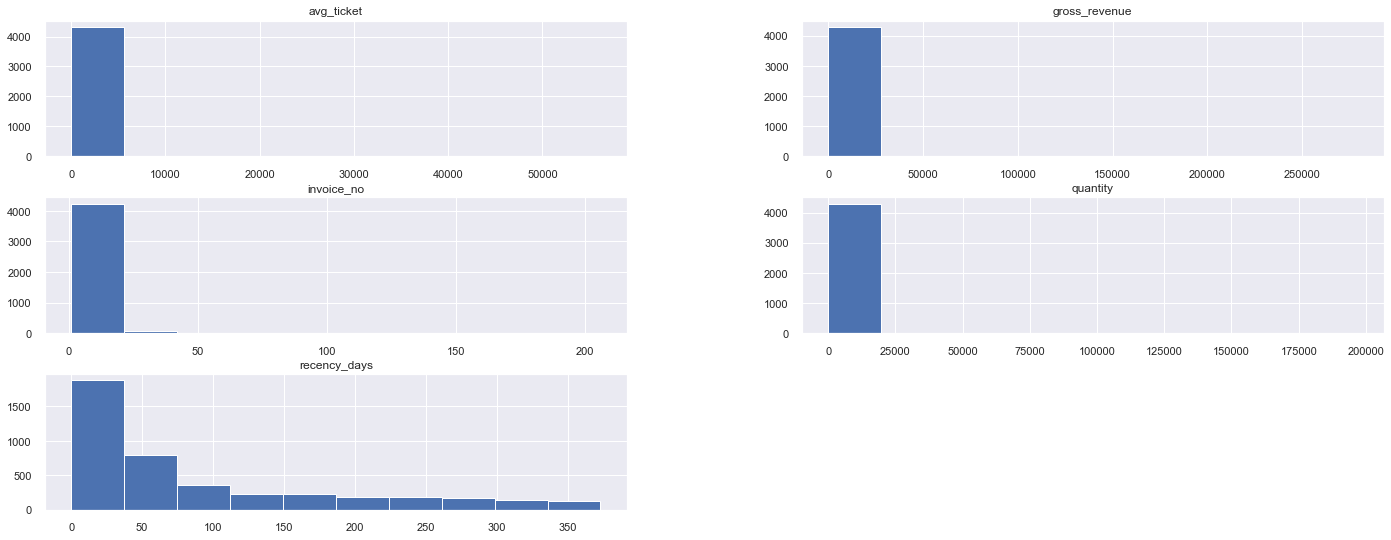

In [32]:
df4.loc[:, df4.columns != 'customer_id'].hist();

In [34]:
num = df4.select_dtypes(include=['float64'])

# Central Tendency - Mean, Median

ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - Min, Max, Standard Deviation, Range, Skew, Kurtosis

d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(np.min)).T
d3 = pd.DataFrame(num.apply(np.max)).T
d4 = pd.DataFrame(num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatanate
num_df = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
num_df.columns =['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_df

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,gross_revenue,2010.165019,668.395000,8865.728552,3.750000,279138.02,279134.270000,19.857180,500.934334
1,recency_days,92.109541,50.000000,100.226676,0.000000,373.00,373.000000,1.245498,0.424526
2,invoice_no,4.259379,2.000000,7.658008,1.000000,206.00,205.000000,11.952414,244.108888
3,avg_ticket,50.219354,17.560833,887.269319,2.101286,56157.50,56155.398714,59.424822,3716.292346
4,quantity,1175.905743,379.000000,4928.018286,1.000000,196844.00,196843.000000,21.182996,660.606732


All the numerical variables have a very skewed distribuition. Their histogram and the descriptive statistics evidence the strong presence of outliers. This presence imposes a challenge to our problem: most probably the outliers are going to be included in our fidelity program built upon the clusterization. 

### 4.1.2 Categorical Variables

## 4.2 Bivariate Analysis

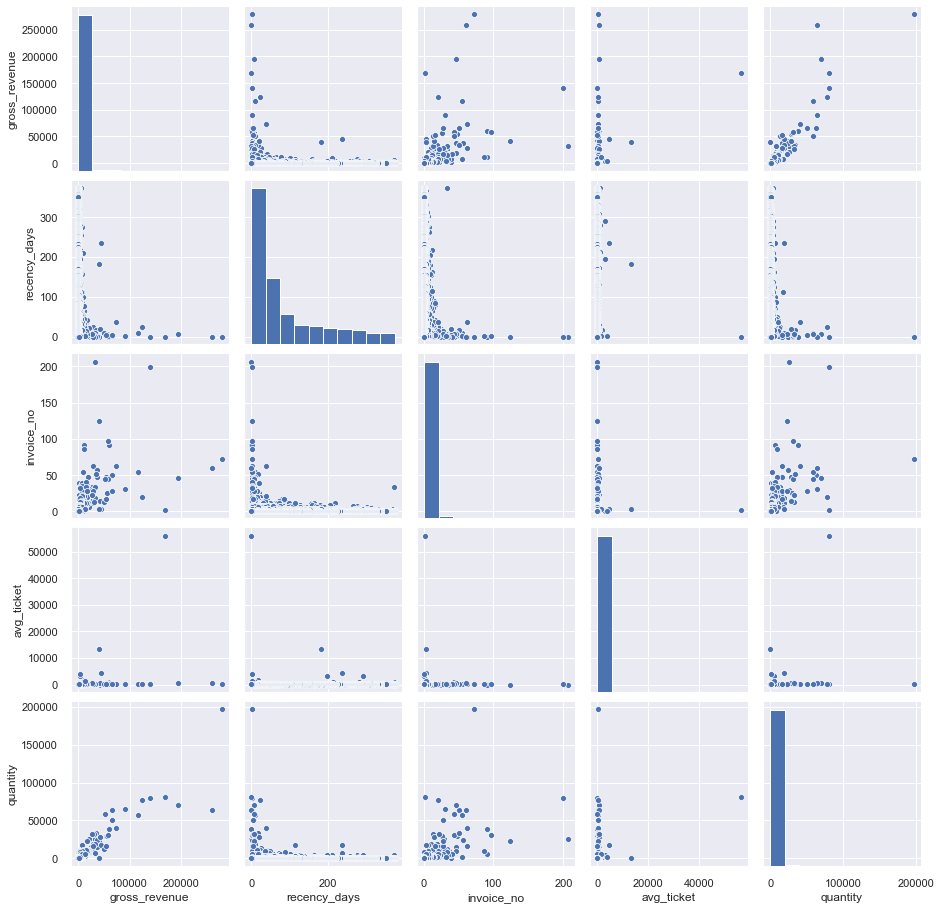

In [55]:
sns.pairplot(df4.loc[:,df4.columns != 'customer_id']);

Again, we can see the presence of outliers, especially if we take `gross_revenue` as our main parameter. All variables have strong outliers that make the analysis difficult: in `recency_days`, there is a customer thar spent almost an year withour purchansing; in `invoice_no`, there are two customers that have almost 200 transactions done or above; in `avg_ticket` there is a client that spent more than 50.000 dollars in average; in `quantity` there is somene that has boought almost 200.000 products.  

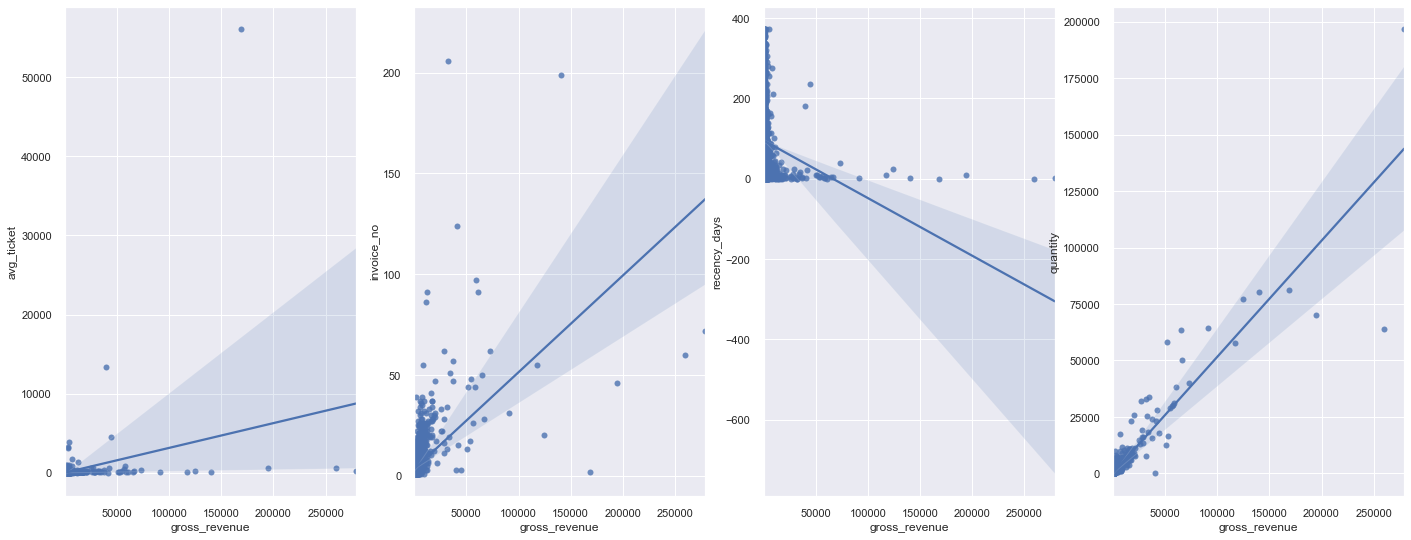

In [62]:
plt.subplot(1,4,1)
sns.regplot(y= 'avg_ticket', x='gross_revenue', data=df4);

plt.subplot(1,4,2)
sns.regplot(y= 'invoice_no', x='gross_revenue', data=df4);

plt.subplot(1,4,3)
sns.regplot(y= 'recency_days', x='gross_revenue', data=df4);

plt.subplot(1,4,4)
sns.regplot(y= 'quantity', x='gross_revenue', data=df4);


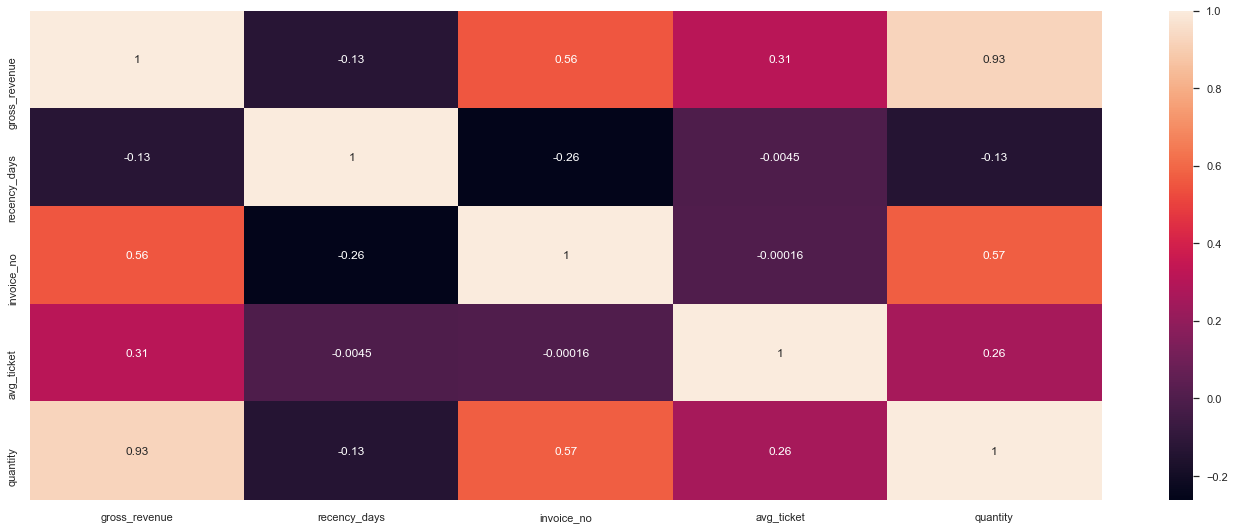

In [64]:
sns.heatmap(df4.loc[:,df4.columns != 'customer_id'].corr(),annot=True);

From both graphs above, we visualize the correlation between the variables. As we would expect, `quantity` has a high correlation to `gross_revenue` because the first is part of the calculation of the latter. `invoice_no` has a relatively strong correlation with `gross_revenue` which is comprehensiable once the more times you buy, the higher is the probabiblity that you spend more. 

* **What we can conclude from the exploratory data analysis is that the outliers have a big impact in the features' behaviour. Therefore, this analysis has shown us more about the data in terms of machine learning performance rather than bussiness knowledge. For this, we need to realize the analysis without the reducing of data granularity and the inclusion of the other variables.**

# 5.0 Data Preparation

In [35]:
df5 = df4.copy()

 **Standard Scaler**

In [36]:
ss = pp.StandardScaler()

df5.gross_revenue = ss.fit_transform(df5[['gross_revenue']])
df5.recency_days = ss.fit_transform(df5[['recency_days']])
df5.invoice_no = ss.fit_transform(df5[['invoice_no']])
df5.avg_ticket = ss.fit_transform(df5[['avg_ticket']])
df5.quantity =  ss.fit_transform(df5[['quantity']])

In [37]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,quantity
0,17850,0.381361,2.792574,3.883597,-0.036141,0.113046
1,13047,0.137882,-0.360279,0.619041,-0.035294,0.043444
2,12583,0.529592,-0.899057,1.402534,-0.024025,0.781672
3,13748,-0.119778,0.028839,0.096712,-0.018431,-0.149534
4,15100,-0.127927,2.403457,-0.164453,0.272500,-0.222383


# 6.0 Feature Selection

In [38]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [39]:
X = df6.drop('customer_id',axis=1)

In [40]:
# Listing possible values for k
clusters =[2,3,4,5,6,7]


## 7.1 Within-Cluster Sum of Square (WSS)

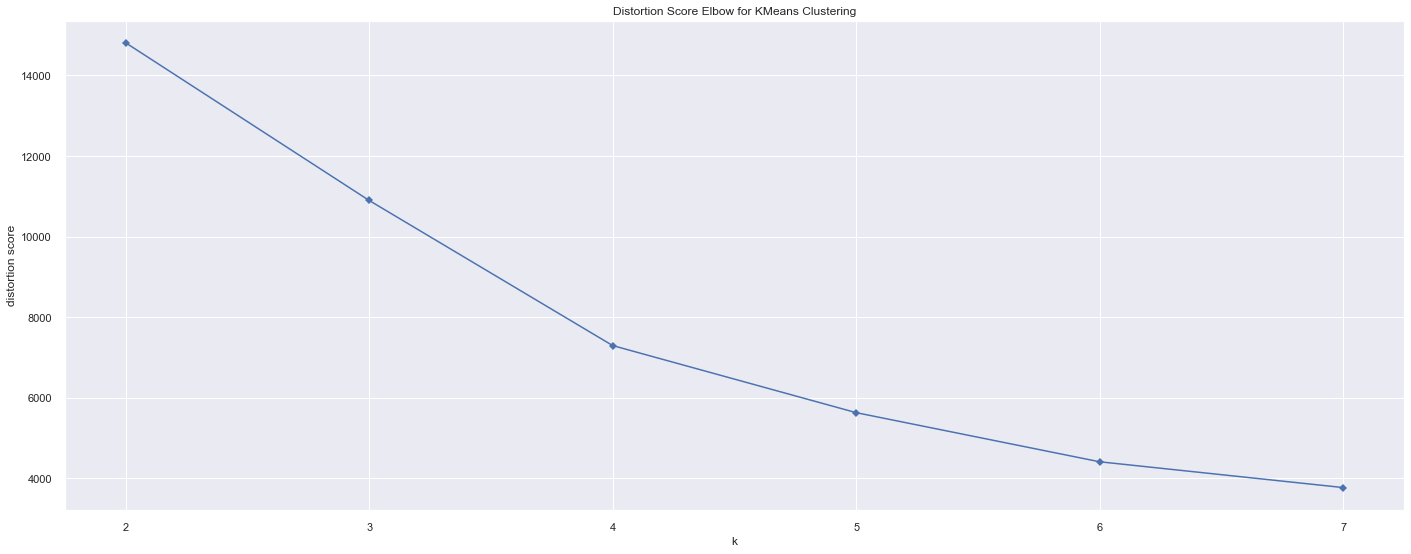

In [41]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, timings=False,
                        locate_elbow=True)
kmeans.fit(X)
kmeans.show();

## 7.2 Sillhouette Score

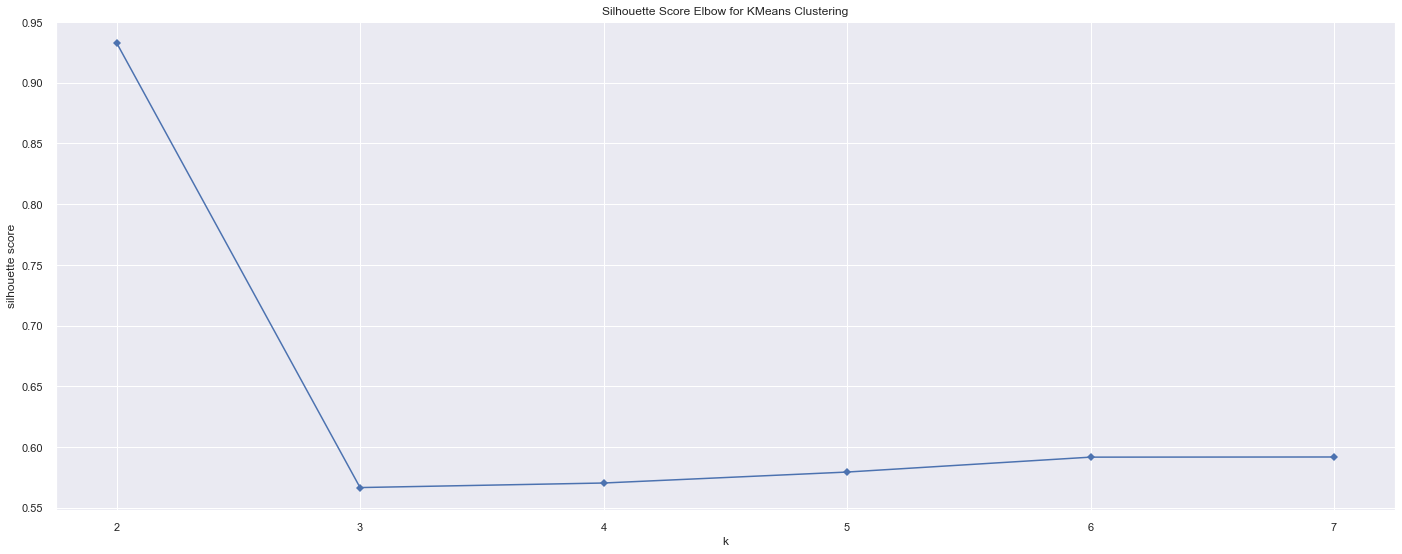

In [42]:
kmeans = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
kmeans.fit(X)
kmeans.show()

## 7.3 Silhouette Analysis

Besides WSS and SS, the Silhouette Analysis allow us to make a better decision in which number of clusters to choose.

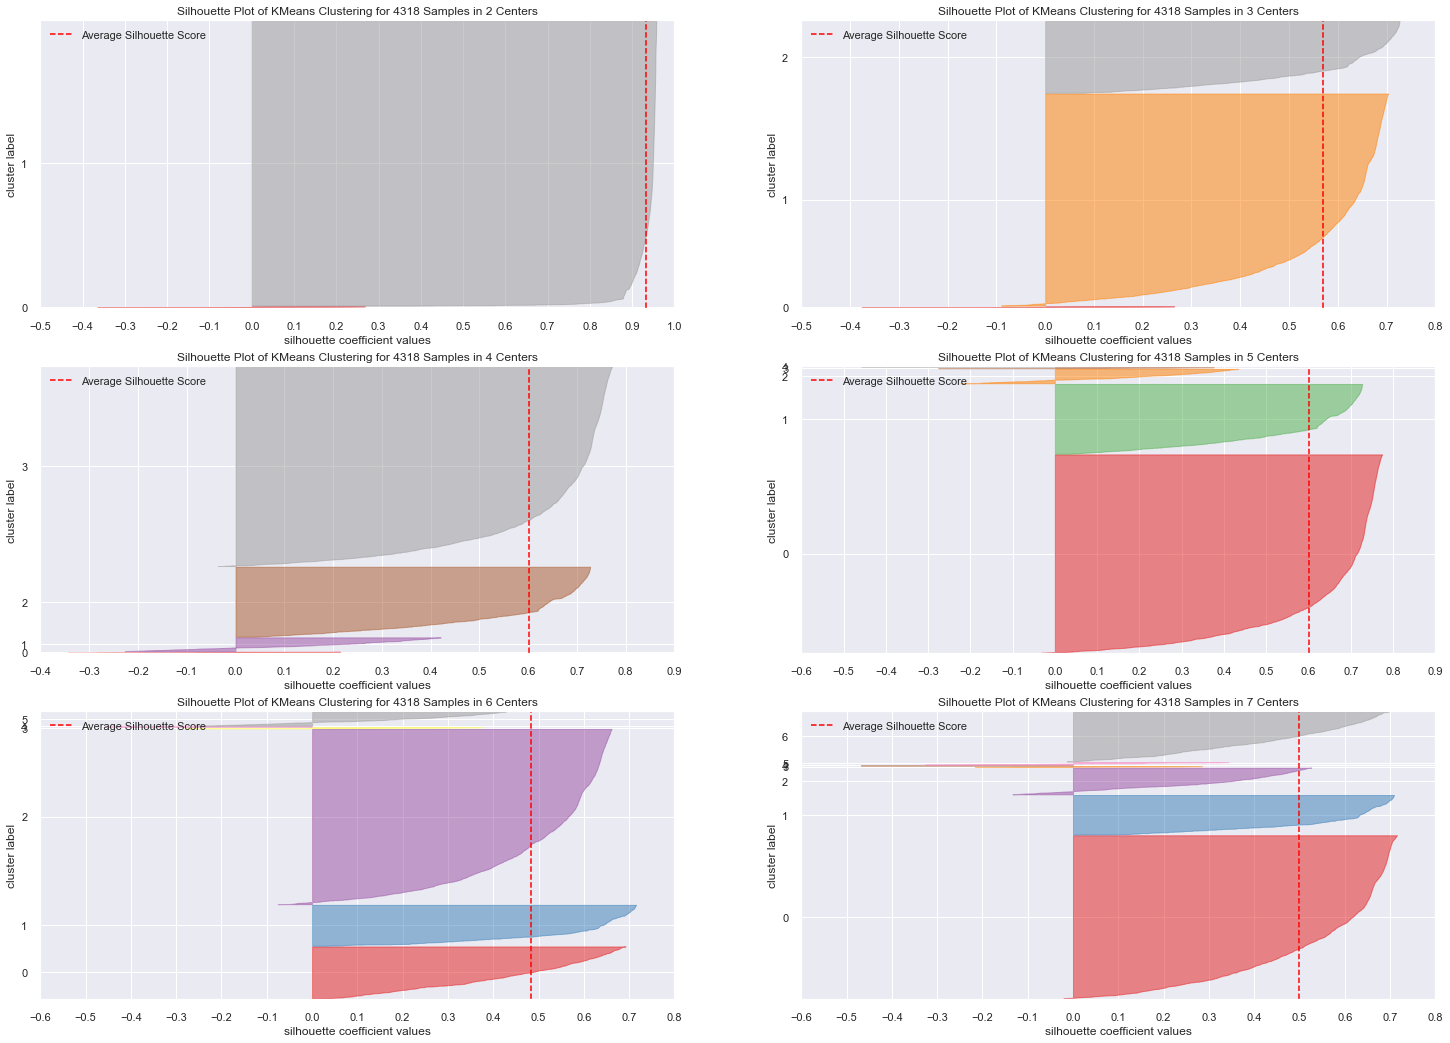

In [43]:
#7.1 Silhouette Analysis

fig, ax = plt.subplots(3,2,figsize=[25,18])
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random',
                n_init=10,
                max_iter=100,
                random_state=42)
    q,mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km,colorts='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [65]:
# Model definition
k = 4
model_train = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model Training
model_train.fit(X)

# Clustering
labels = model_train.labels_

## 8.2 Cluster Validation

In [66]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( model_train.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 9616.485183970044
SS value: 0.6018916929771626


# 9.0 Cluster Analysis

In [67]:
df9 =df6.copy() 

# Adding the clustes 
df9['cluster'] = labels

df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,quantity,cluster
0,17850,0.381361,2.792574,3.883597,-0.036141,0.113046,1
1,13047,0.137882,-0.360279,0.619041,-0.035294,0.043444,3
2,12583,0.529592,-0.899057,1.402534,-0.024025,0.781672,1
3,13748,-0.119778,0.028839,0.096712,-0.018431,-0.149534,3
4,15100,-0.127927,2.403457,-0.164453,0.272500,-0.222383,2


## 9.1 Visualization Inspection

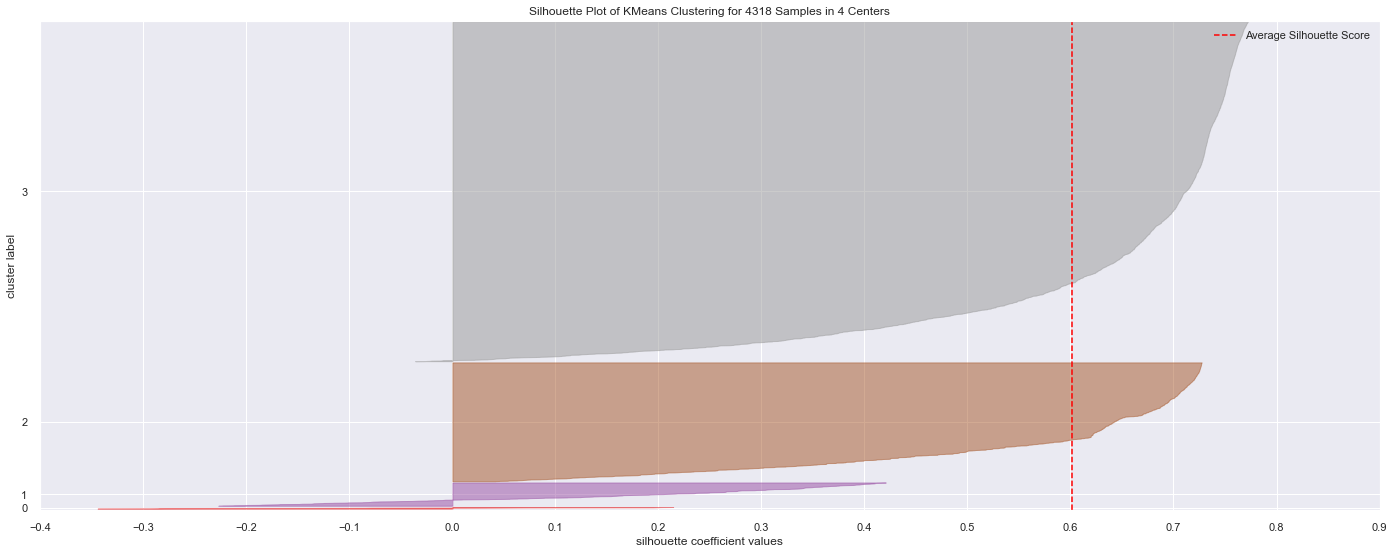

In [68]:
km = c.KMeans(n_clusters= k , init='random',
                n_init=10,
                max_iter=100,
                random_state=42)
visualizer = SilhouetteVisualizer(km,colorts='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d Plot

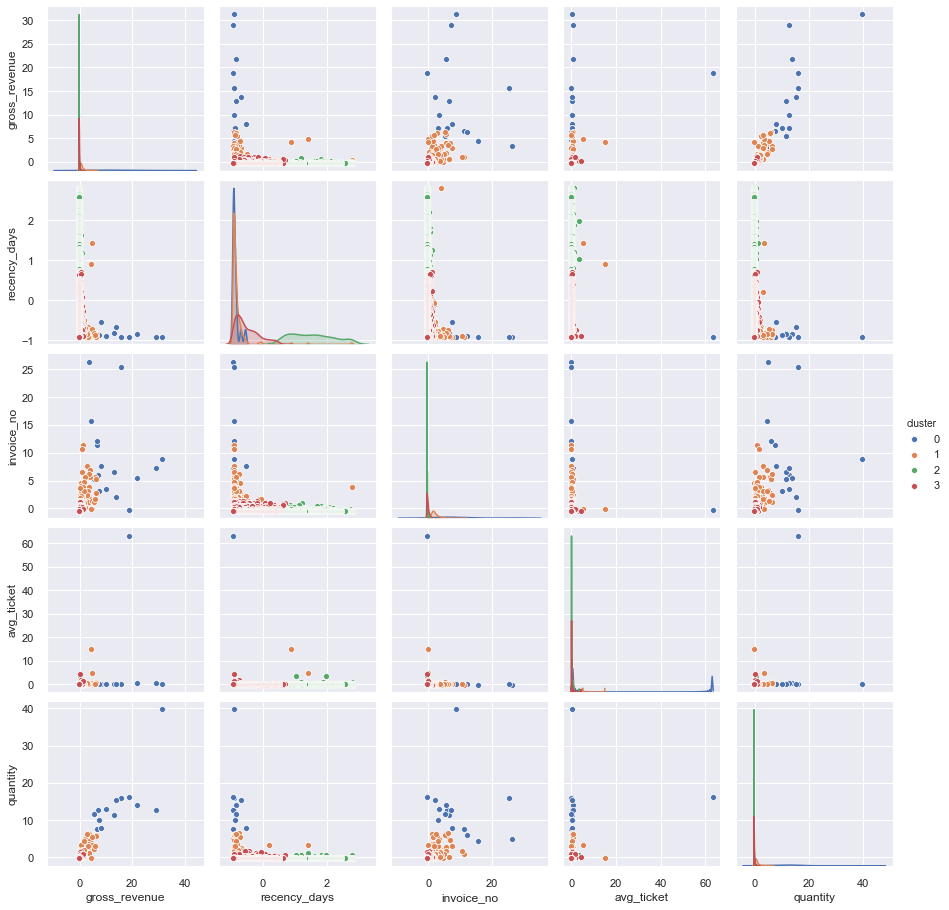

In [69]:
df_viz = df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP

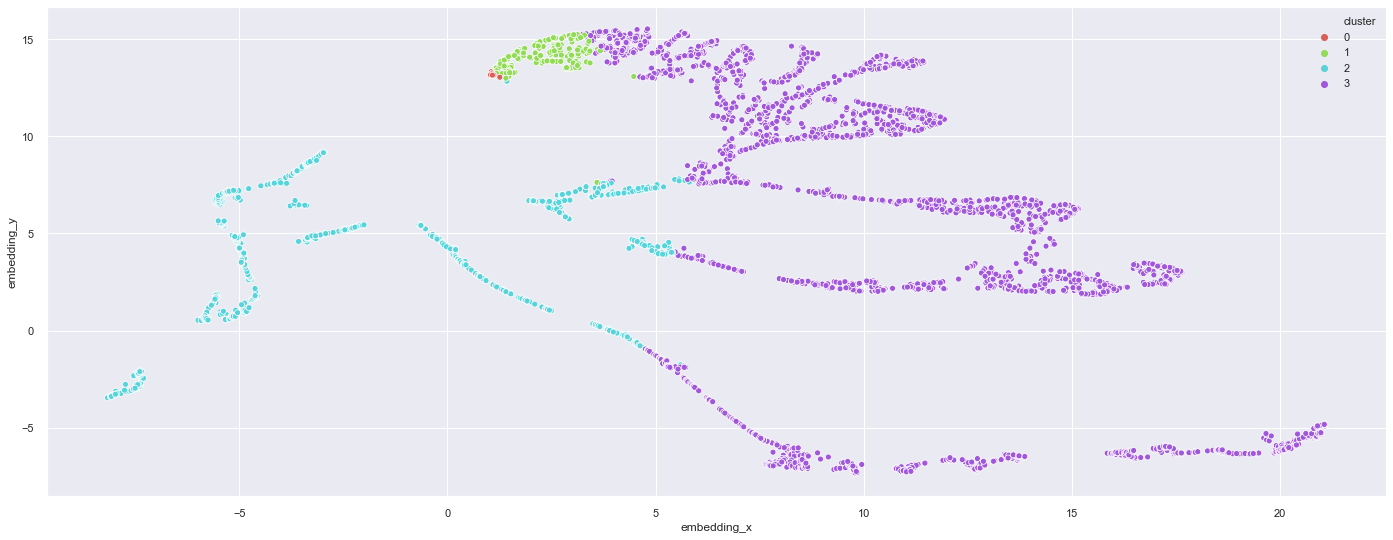

In [70]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot view
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster', data=df_viz, palette=sns.color_palette('hls',n_colors=len(df_viz.cluster.unique())));


## 9.4 Cluster Profile

In [50]:
### INVERSE TRANSFORM NOT WORKING FOR SOME REASON
## Undo the data transformation

# df9.gross_revenue = ss.inverse_transform(df5[['gross_revenue']])
# df9.recency_days = ss.inverse_transform(df5[['recency_days']])
# df9.invoice_no = ss.inverse_transform(df5[['invoice_no']])
# df9.avg_ticket = ss.inverse_transform(df5[['avg_ticket']])
# df9.quantity = df9.avg_ticket = ss.inverse_transform(df5[['quantity']])


In [71]:
df9.drop(['gross_revenue', 'recency_days', 'invoice_no','avg_ticket','quantity'],axis=1, inplace=True)
df9 = pd.merge(df4, df9,how='inner', on='customer_id')

In [72]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')

# Average Invoice Number
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner',on='cluster')

# Average Ticket 
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner',on='cluster')

# Quantity
df_quantity = df9[['quantity','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_quantity, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket,quantity
0,0,16,0.370542,114016.075625,6.312500,74.187500,3663.114637,63873.312500
1,1,209,4.840204,11382.535455,13.531100,21.502392,138.949638,6440.200957
2,2,1062,24.594720,475.927759,248.265537,1.542373,39.228228,270.385122
3,3,3031,70.194535,1310.211201,43.266909,3.653250,28.880398,799.220389


# 10.0 Deploy